In [7]:
import numpy as np
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import ipywidgets as widgets
from IPython.display import display
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from klusta.kwik import KwikModel
from scipy import signal
import os
import sys
import kwikfile as kf
import seaborn as sns



class MicroMatrix:
    
    def __init__(self,V=None,Nx=70,Ny=200,kpath=None):
        """!  @brief Creates a MicroMatrix instance.
        
        Parameters:
        V: Matrix 2D containing the potential distribution in the microspace for a microinstant.
        Nx: Number of matrix columns.
        Ny: Number of matrix rows.
        kpath: Path to the '.kwik' file.
        
        Example: 
        mm=MicroMatrix(V=None,kpath="/some directory where there is kwikfile")
        Once you downloaded the examples from the phy project in the /tmp directory. You can to instanciate 
        a MicroMatrix object using this:
        mm=MicroMatrix(V=None,kpath="/home/adm/data/2016Apr15/spk/manual/01/g01.kwik")
    
        @author: Harison P B de Oliveira
        @date: 2018.May.25        
        """
        
        if Nx<50 or Ny<190:
            print("Dimensions of the matrix smaller than the electrode dimensions.")
            return
        else:
            self.Nx=Nx
            self.Ny=Ny
            self.kwik_model=None
            self.kwikfile=None
            self.kpath=None
            if kpath is not None:
                if os.path.exists(kpath) is True:
                    self.kwik_model=KwikModel(kpath)
                    self.kpath=kpath
                    self.kwikfile=kf.KwikFile(kpath)
                    self.geometry=np.matrix([np.flipud (self.kwik_model.channel_positions [:,0])
                                             ,np.flipud (self.kwik_model.channel_positions [:,1]) ])
                else:
                    print('The file was not found in the directory informed.')
                    return
                if V is None:        
                    self.V=np.zeros((Ny,Nx))
                else:
                    if V.shape[0]<50 and V.shape[1]<190:
                        print("Dimensions of the matrix informed is smaller than the electrode dimensions.")
                        return
                    else:
                        if V.shape[0] is Nx and V.shape[1] is Ny:
                            self.V=V
                        else:
                            self.V=zeros((Ny,Nx))
                            warnings.warn('The dimensions of V were replaced by (Ny, Nx).', Warning)
            else:
                print("Enter a valid kpath.")

                
                
    def reset_matrix (self):
        """!  @brief Reset the matrix.
            
        @author: Harison P B de Oliveira
        @date: 2018.May.25
        """
        
        self.V=np.zeros((self.Ny,self.Nx))
        
    def set_ini_conditions(self,potentials):
        """!  @brief Sets the potential matrix with initial conditions.
    
        Parameters:
        Input: 
            - potentials: list of electric potentials across channels in a given time sample.
        Output:
            - <None>
        
        @author: Harison P B de Oliveira
        @date: 2018.May.25
        """
        
        if potentials.shape[0]==10 and self.V is not None:
            self.reset_matrix()
            x_offset = (self.Nx-(np.max(self.geometry[0,:])-np.min(self.geometry[0,:])))/2
            y_offset = (self.Ny-(np.max(self.geometry[1,:])-np.min(self.geometry[1,:])))/2    
            for ch in range (0,self.geometry.shape[1]):
                x_i=int(self.geometry[0,ch]-5+x_offset)
                x_f=int(self.geometry[0,ch]+5+x_offset)
                y_i=int(self.geometry[1,ch]-8+y_offset)
                y_f=int(self.geometry[1,ch]+8+y_offset)
                if x_i >=0 and y_i>=0:
                    self.V[y_i:y_f,x_i:x_f]=potentials[ch]
        else:
            print('Number of potentials out of target.')
            return
    
    
    
    def calc_matrix(self,maxIter=500,th=0.1):
        """!  @brief Returns an array for each of the 32 intervals showing the potential distribution of the 
        microspace.
        
        Parameters:
        waves: Array containing the potential of each site.
        maxIter: Maximum number of iterations.
        
        @author: Harison P B de Oliveira
        @date: 2018.May.31
        """
        
        if self.V is None:
            raise ValueError("Potential array is None.")
        if maxIter<0:
            raise ValueError("The number of maximum iterations must be greater than zero.")
        
        max_diff=sys.maxsize
        count_inter=0
        while max_diff>th and count_inter<maxIter:
            for i in range(1,self.V.shape[0]-1):
                for j in range(1,self.V.shape[1]-1):
                    prev=self.V[i,j]
                    self.V[i,j]=0.25 * (self.V[i+1][j] + self.V[i-1][j] 
                                                + self.V[i][j+1] + self.V[i][j-1])
                    d=np.abs(prev-self.V[i,j])
                    if (d>max_diff):
                        max_diff=d
            count_inter+=1
    
    
    def save_to_numpy(self,filename,overwrite=False):
            """!  @brief Saves an '.npy' file containing the potential distribution in the microspace for 
            a microinstant.

            parameters:

            filename: name of the file where the MicroMatrix must be saved.

            @author: Nivaldo A P de Vasconcelos
            @date: 2018.Jun.28
            """
            '''
            Errors:
                - input is a folder
                - File already exists and overwrite is FALSE
                - Does not have permission to write file
            '''


            if (os.path.isdir(filename)):
                self.error_msg="The input can not be a folder, but a file"
                raise ValueError(filename)
            # File already exists and overwrite is FALSE
            if (os.path.exists(filename)) and not (overwrite):        
                self.error_msg="File alredy exists and can not be overwritten"
                raise FileExistsError(filename)

            # Does not have permission to write file
            try:
                file = open(filename, 'w')
                file.close()
            except IOError as e:
                self.error_msg="Caught the I/O error"
                raise IOError(filename)
            np.save(filename,self.V)
    
    def load_to_numpy(self,filename):
        """!  @brief Loads a '.npy' file containing the potential distribution in the microspace for 
        a microinstant.
        
        parameters:

        filename: name of the file where the MicroMatrix must be saved.
        
        @author: Harison P B de Oliveira
        @date: 2018.Jul.04
        """
        '''
        Errors:
            - input is a folder
            - File already exists and overwrite is FALSE
            - Does not have permission to write file
        '''
        
        if (os.path.isdir(filename)):
            #self.error_msg="The input can not be a folder, but a file"
            raise ValueError("The input can not be a folder, but a file")
        # File does not exist
        if (os.path.exists(filename)) is False:        
            #self.error_msg="File does not exist."
            raise ValueError("File does not exist.")
        # Does not have permission to read file
        try:
            file = open(filename, 'r')
            file.close()
        except IOError as e:
            #self.error_msg="Caught the I/O error"
            raise ValueError("Caught the I/O error")
        self.V=np.load(filename)
                        
    def show_matrix(self,xlim=3,ylim=10):
        """!  @brief Shows graphically the matrix with the distribution of potentials.
        
        parameters:
        xlim: Width of the output image.
        ylim: Height of the output image.
        
        @author: Harison P B de Oliveira
        @date: 2018.Jun.25
        """
        
        if self.V is None:
            #self.error_msg='The matrix containing the potential distribution in the microspace for a microinstant is None.'
            raise ValueError('The matrix containing the potential distribution in the microspace for a microinstant is None.')
        if xlim<0 or ylim<0:
            #self.error_msg='he dimensions of the image can not be less than zero.'
            raise ValueError('He dimensions of the image can not be less than zero.')
        plt.figure(figsize=(xlim,ylim))
        ax=sns.heatmap(mm.V*-1,yticklabels=False,xticklabels=False,cmap='jet',cbar_kws={"orientation": "vertical"})
    
    ''' REMOVE '''         
    def amplitudes_spike_id(self,group_name=None,spk_id=None):
        """!  @brief Returns the waveform of a list of spikes id.
        
        @author: Harison P B de Oliveira
        @date: 2018.Jun.15
        """
        
        w=self.kwik_model.all_waveforms
        if spk_id is None and group_name is not None:
            spk_id=self.kwikfile.all_spike_id_on_groups(group_names=group_name)
        elif spk_id is None and group_name is None:
            raise ValueError("\nReport a valid group_name.\n")
        wf=w[spk_id]    
        return wf
    
    
    
            
        

In [8]:
kpath="/home/harison/UFPE/data/g01.kwik"
#kpath="/home/nvasconcelos/data/atropine/2018May09/01/g01.kwik"
mm=MicroMatrix(kpath=kpath)


Created class on = /home/harison/UFPE/data/g01.kwik !


In [9]:
w=mm.amplitudes_spike_id(group_name="good",spk_id=6)
w.shape

(1, 32, 10)

(10,)

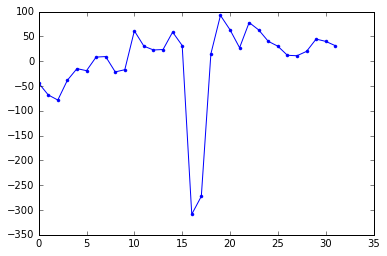

In [10]:
plt.plot (w[0,:,4],'.-')
w[0,0,:].shape

In [11]:
mm.set_ini_conditions(w[0,0,:])

In [12]:
mm.calc_matrix(th=0.1)

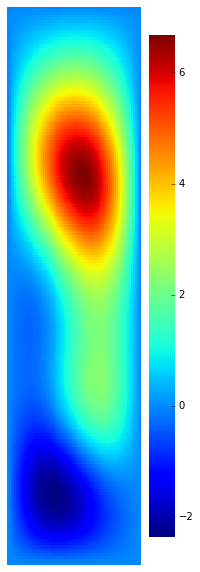

In [13]:
mm.show_matrix()

In [14]:
mm.save_to_numpy(microinstant=0)

In [15]:
mm.load_to_numpy(microinstant=0)

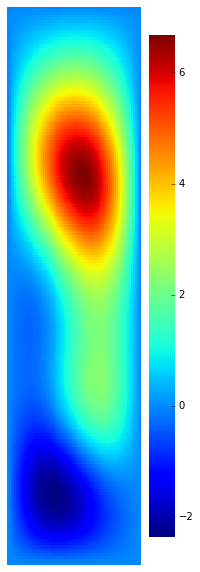

In [16]:
mm.show_matrix()

In [16]:
group_name='good'
spk_id=kwikfile.all_spike_id_on_groups(group_names=[group_name])
wav=mm.amplitudes_spike_id(group_name=group_name,spk_id=spk_id[0])

In [38]:
a=np.load('matrix_0.npy')
a.shape

(200, 70)